# Project Section2 - Machine Learning
## AI-08-박우석

## 프로젝트 데이터 : Rain in Australia
호주의 여러 지역에서 측정된 온도, 풍향, 습도 등 주어진 데이터를 통해 다음날 비가 왔는지를 예측해 볼 수 있다.

**Target : RainTomorrow (Yes or No)**

### 데이터를 선정한 이유
기상청에서도 잘 예측하지 못하여 우리가 늘 불평하는 날씨 예보. 우리 스스로는 얼마나 정확하게 이를 예측할 수 있는지 머신러닝으로 확인해 보고 싶었다.

- 문제의 유형 -> yes or no 를 판별하는 것이므로 **Classification** 문제로 접근한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report


from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

import missingno as msno
import seaborn as sns

import imblearn
from imblearn.over_sampling import RandomOverSampler

from scipy.stats import randint, uniform



In [2]:
pd.read_csv('/Users/wooseokpark/Documents/codestates/rain-in-aus/weatherAUS.csv').head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

### Baseline model 설정 : 항상 비가 오지 않는 것으로 예측

In [3]:
aus_base = pd.read_csv('/Users/wooseokpark/Documents/codestates/rain-in-aus/weatherAUS.csv')

# yes -> 1, no -> 0 으로 바꾸어줌
def yesno(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    
aus_base['RainToday'] = aus_base['RainToday'].apply(yesno)
aus_base['RainTomorrow'] = aus_base['RainTomorrow'].apply(yesno)

# 결측치 제거
aus_base = aus_base.dropna(subset=['RainToday', 'RainTomorrow'])

# baseline model - 항상 비가 오지 않을 것으로 예측
y_pred_base = pd.DataFrame({'RainTomorrow':np.zeros(len(aus_base['RainToday']))})
y_test = aus_base[['RainTomorrow']]

accuracy = classification_report(y_test[:-1], y_pred_base[:-1])
print(accuracy)

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88    109585
         1.0       0.00      0.00      0.00     31201

    accuracy                           0.78    140786
   macro avg       0.39      0.50      0.44    140786
weighted avg       0.61      0.78      0.68    140786



/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

baseline model 결과:  
이미 accuracy가 78%에 달한다. 상당한 imbalance가 타겟에 존재하기 때문.  
averaged f1 score : 0.44

### EDA 및 데이터 전처리

<AxesSubplot:>

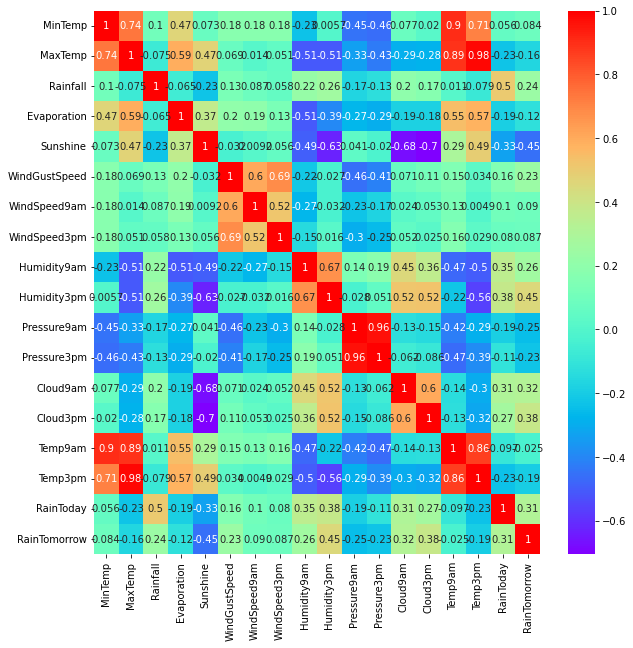

In [4]:
# feature 간의 correlation 파악하기 
# 높은 correlation 보이는 feature들은 통일하거나 없앤다.

plt.figure(figsize=(10,10))
sns.heatmap(aus_base.corr(),
           annot=True,
           cmap='rainbow')

<AxesSubplot:>

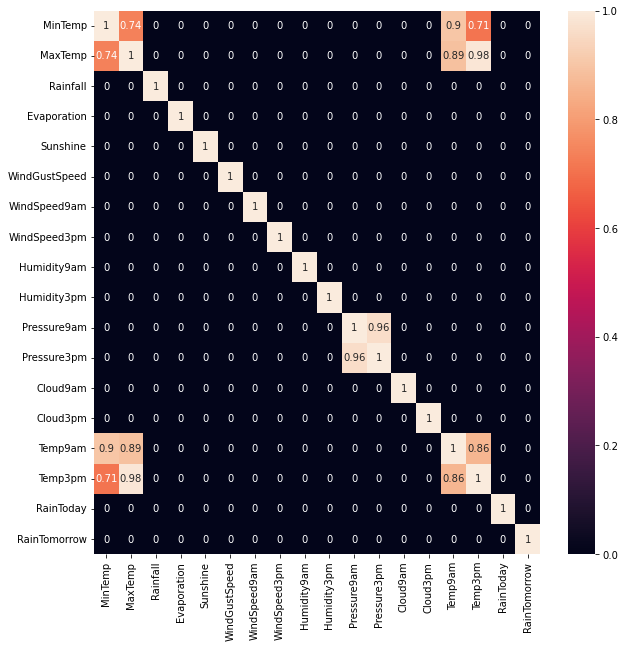

In [5]:
aus_base_high = aus_base.corr().copy()
aus_base_high[~(aus_base_high > 0.7) ] = 0

plt.figure(figsize=(10,10))
sns.heatmap(aus_base_high,
           annot=True,
           )

Temperature 그리고 pressure 끼리 상당히 높은 correlation을 보이고 있다.  
따라서 mean Temperature / mean pressure 지표를 만들어 통일한다.

#### 결측치 확인

<AxesSubplot:>

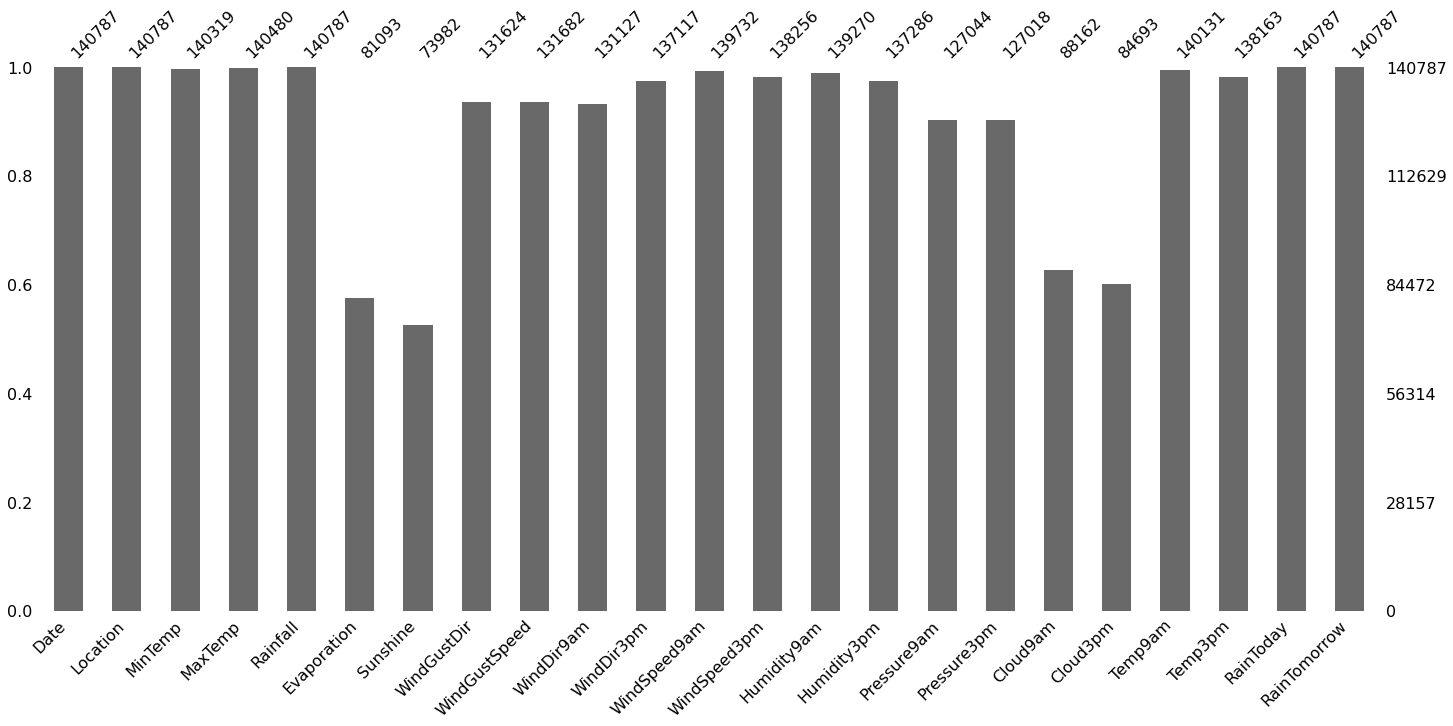

In [6]:
%matplotlib inline
msno.bar(aus_base)

Evaporation, Sunshine, Cloud는 너무 결측치가 많고 유추하기도 힘들기 때문에 관련 파라미터는 모두 제거한다.

### 데이터 전처리

In [7]:
aus = pd.read_csv('/Users/wooseokpark/Documents/codestates/rain-in-aus/weatherAUS.csv')
print(aus.shape)


#RainToday, RainTomorrow 결측치 행 제거
aus = aus.dropna(subset=['RainToday','RainTomorrow'])

# evaporation, sunshine, cloud는 너무 결측치가 많고 유추하기도 힘들다. 따라서 그냥 제거한다
aus = aus.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis=1)

#기타 결측치 제거
aus = aus.dropna()
print('After dropna:',aus.shape)


#RainToday and RainTomorrow values change to 0 and 1
def yesno(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
aus['RainToday'] = aus['RainToday'].apply(yesno)
aus['RainTomorrow'] = aus['RainTomorrow'].apply(yesno)

#meanTemp 계산
aus['MeanTemp'] = aus.loc[:,['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].mean(axis=1)

#meanpressure 계산
aus['MeanPressure'] = aus.loc[:,['Pressure9am', 'Pressure3pm']].mean(axis=1)





(145460, 23)
After dropna: (112925, 19)


WindDir (바람의 방향) : 16가지 방향으로 나뉘어져 있다. 이를 manual 하게 동쪽 : 0 부터 시계방향으로 0~15까지 숫자를 매겼다

In [8]:
aus.loc[:,['WindGustDir', 'WindDir9am', 'WindDir3pm']]

WindGustDir WindDir9am WindDir3pm
0                W          W        WNW
1              WNW        NNW        WSW
2              WSW          W        WSW
3               NE         SE          E
4                W        ENE         NW
...            ...        ...        ...
145454           E        ESE          E
145455           E         SE        ENE
145456         NNW         SE          N
145457           N         SE        WNW
145458          SE        SSE          N

[112925 rows x 3 columns]

In [9]:
# WindDir manual encoding

def dir_to_num(valdir):

    ref = {'E':0,
         'ESE':1,
         'SE':2,
         'SSE':3,
         'S':4,
         'SSW':5,
         'SW':6,
         'WSW':7,
         'W':8,
         'WNW':9,
         'NW':10,
         'NNW':11,
         'N':12,
         'NNE':13,
         'NE':14,
         'ENE':15
         }
    return ref[valdir]

aus['WindGustDir'] = aus['WindGustDir'].apply(dir_to_num)
aus['WindDir9am'] = aus['WindDir9am'].apply(dir_to_num)
aus['WindDir3pm'] = aus['WindDir3pm'].apply(dir_to_num)

aus.loc[:,['WindGustDir', 'WindDir9am', 'WindDir3pm']]



WindGustDir  WindDir9am  WindDir3pm
0                 8           8           9
1                 9          11           7
2                 7           8           7
3                14           2           0
4                 8          15          10
...             ...         ...         ...
145454            0           1           0
145455            0           2          15
145456           11           2          12
145457           12           2           9
145458            2           3          12

[112925 rows x 3 columns]

In [10]:
# train / test 나누기. 2016년부터 test data로 남겨둠
train = aus[aus['Date'] <= '2016']
test = aus[aus['Date'] > '2016']
train.shape, test.shape

# feature and target selection
features = train.columns.drop(['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 
                               'Pressure9am', 'Pressure3pm',
                               'RainTomorrow'])
target = 'RainTomorrow'


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


### Oversampling

타겟 데이터의 불균형이 4:1 정도이므로, 모델 학습에서 불균형을 줄이기 위해   
적은 데이터(내일 비가 오는 데이터)를 oversampling 하여 **늘어난 훈련 데이터**를 만든다.

In [11]:
# Oversample RainTomorrow = 1 data
oversample = RandomOverSampler(sampling_strategy='minority', random_state=33)

X_over, y_over = oversample.fit_resample(X_train, y_train)

X_train.shape, X_over.shape

((92513, 14), (144352, 14))

**Encoding and Scale**  

OrdinalEncoder : Date, Location  
Scale : Rainfall, WindGustSpeed, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm,
MeanTemp, MeanPressure

### 머신러닝 모델 성능 비교

LogisticRegression / DecisionTree / LightGBM / RandomForestClassifier 로 모델 성능을 비교하였다.  
LogisticRegression은 파라미터 조정 없이 Cross-validation 진행.  
나머지 모델들은 RandomizedSearchCV 를 이용해 최적의 파라미터를 탐색하였다.

**Logistic Regression**

In [12]:
pipe_logreg = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        LogisticRegression()
)
    

logreg_score = cross_val_score(
                    pipe_logreg,
                    X_over,
                    y_over,
                    cv=5,
                    n_jobs=-1,
                    verbose=0,
                    scoring='f1'
                )

print(logreg_score)
print('Logistic Regression average F1 score:', logreg_score.mean())

[0.69937944 0.74522206 0.76719357 0.78049295 0.74465542]
Logistic Regression average F1 score: 0.7473886885326441


**Decision Tree**

In [13]:
pipe = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        DecisionTreeClassifier()
)
    
params = {
    'decisiontreeclassifier__max_depth': [1,3,5,7],
    'decisiontreeclassifier__min_samples_split': [2,4,6,8],

    
}
    
clf = RandomizedSearchCV(
            pipe,
            param_distributions=params,
            n_iter=50,
            cv=5,
            scoring='f1',
            verbose=1,
            n_jobs=-1
)
    
clf.fit(X_over, y_over)

/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Date',
                                                                   'Location'])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('decisiontreeclassifier',
                                              DecisionTreeClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'decisiontreeclassifier__max_depth': [1,
                                                                              3,
                                                                              5,
                                                                              7],
                                        'decisiontreeclassifier__min_samples_split': [2,
                       

In [14]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

0   \
mean_fit_time                                                                              0.22319   
std_fit_time                                                                              0.027555   
mean_score_time                                                                           0.020056   
std_score_time                                                                            0.004059   
param_decisiontreeclassifier__min_samples_split                                                  2   
param_decisiontreeclassifier__max_depth                                                          1   
params                                           {'decisiontreeclassifier__min_samples_split': ...   
split0_test_score                                                                         0.711589   
split1_test_score                                                                         0.677544   
split2_test_score                                                                         0.700325   
split3_test_score                                                                         0.721713   
split4_test_score                                                                         0.724821   
mean_test_score                                                                           0.707198   
std_test_score                                                                             0.01713   
rank_test_score                                                                                  1   

                                                                                                1   \
mean_fit_time                                                                             0.209858   
std_fit_time                                                                              0.017316   
mean_score_time                                                                           0.019619   
std_score_time                                                                            0.007369   
param_decisiontreeclassifier__min_samples_split                                                  4   
param_decisiontreeclassifier__max_depth                                                          1   
params                                           {'decisiontreeclassifier__min_samples_split': ...   
split0_test_score                                                                         0.711589   
split1_test_score                                                                         0.677544   
split2_test_score                                                                         0.700325   
split3_test_score                                                                         0.721713   
split4_test_score                                                                         0.724821   
mean_test_score                                                                           0.707198   
std_test_score                                                                             0.01713   
rank_test_score                                                                                  1   

                                                                                                2   \
mean_fit_time                                                                             0.179838   
std_fit_time                                                                              0.032001   
mean_score_time                                                                           0.016686   
std_score_time                                                                            0.003456   
param_decisiontreeclassifier__min_samples_split                                                  6   
param_decisiontreeclassifier__max_depth                                                          1   
params                                           {'decisiontreeclassifier__min_samples_split': ...   
split0_test_sc

In [15]:
pipe = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        LGBMClassifier()
)
    
params = {
    'lgbmclassifier__num_leaves': [10,30,50,70,100],
    'lgbmclassifier__max_depth': [3,5,10,-1],
    'lgbmclassifier__n_estimators': randint(50,500),
    
}
    
clf = RandomizedSearchCV(
            pipe,
            param_distributions=params,
            n_iter=50,
            cv=5,
            scoring='f1',
            verbose=1,
            n_jobs=-1
)
    
clf.fit(X_over, y_over)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Date',
                                                                   'Location'])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('lgbmclassifier',
                                              LGBMClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lgbmclassifier__max_depth': [3, 5, 10,
                                                                      -1],
                                        'lgbmclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17cc6c7c0>,
                                        'lgbmclassifier__num_leaves': [10, 30,
                                                                       50, 70,

In [16]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

37  \
mean_fit_time                                                                4.219508   
std_fit_time                                                                 0.025445   
mean_score_time                                                              1.094693   
std_score_time                                                               0.076576   
param_lgbmclassifier__max_depth                                                    10   
param_lgbmclassifier__n_estimators                                                422   
param_lgbmclassifier__num_leaves                                                   70   
params                              {'lgbmclassifier__max_depth': 10, 'lgbmclassif...   
split0_test_score                                                            0.630437   
split1_test_score                                                            0.632802   
split2_test_score                                                            0.650821   
split3_test_score                                                            0.670301   
split4_test_score                                                            0.640071   
mean_test_score                                                              0.644886   
std_test_score                                                               0.014554   
rank_test_score                                                                     1   

                                                                                   24  \
mean_fit_time                                                                3.764854   
std_fit_time                                                                 0.042325   
mean_score_time                                                              0.974488   
std_score_time                                                               0.089018   
param_lgbmclassifier__max_depth                                                    10   
param_lgbmclassifier__n_estimators                                                401   
param_lgbmclassifier__num_leaves                                                   70   
params                              {'lgbmclassifier__max_depth': 10, 'lgbmclassif...   
split0_test_score                                                            0.629394   
split1_test_score                                                            0.631683   
split2_test_score                                                            0.650056   
split3_test_score                                                            0.669457   
split4_test_score                                                            0.638424   
mean_test_score                                                              0.643803   
std_test_score                                                               0.014702   
rank_test_score                                                                     2   

                                                                                   41  \
mean_fit_time                                                                4.306744   
std_fit_time                                                                 0.067512   
mean_score_time                                                              1.090016   
std_score_time                                                               0.048744   
param_lgbmclassifier__max_depth                                                    10   
param_lgbmclassifier__n_estimators                                                482   
param_lgbmclassifier__num_leaves                                                   50   
params                              {'lgbmclassifier__max_depth': 10, 'lgbmclassif...   
split0_test_score                                                            0.626181   
split1_test_score                                                            0.623159   
split2_test_score                                                           

In [17]:
pipe = make_pipeline(
        OrdinalEncoder(cols=['Date','Location']),
        StandardScaler(),
        RandomForestClassifier()
)
    
params = {
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__n_estimators': [20,50,100,200], #50, 500
    'randomforestclassifier__max_features': uniform(0,1)

    
}
    
clf = RandomizedSearchCV(
            pipe,
            param_distributions=params,
            n_iter=20,
            cv=3,
            scoring='f1',
            verbose=1,
            n_jobs=-1
)
    
clf.fit(X_over, y_over)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['Date',
                                                                   'Location'])),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              15,
                                                                              20,
                                                                              None],
                         

In [18]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

3   \
mean_fit_time                                                                        4.050528   
std_fit_time                                                                         0.063132   
mean_score_time                                                                      0.508217   
std_score_time                                                                       0.063103   
param_randomforestclassifier__max_depth                                                  None   
param_randomforestclassifier__max_features                                           0.080046   
param_randomforestclassifier__n_estimators                                                 50   
params                                      {'randomforestclassifier__max_depth': None, 'r...   
split0_test_score                                                                    0.666261   
split1_test_score                                                                    0.783653   
split2_test_score                                                                    0.684615   
mean_test_score                                                                      0.711509   
std_test_score                                                                        0.05156   
rank_test_score                                                                             1   

                                                                                           9   \
mean_fit_time                                                                       20.172477   
std_fit_time                                                                         0.211569   
mean_score_time                                                                      0.327155   
std_score_time                                                                       0.044059   
param_randomforestclassifier__max_depth                                                  None   
param_randomforestclassifier__max_features                                            0.60764   
param_randomforestclassifier__n_estimators                                                 50   
params                                      {'randomforestclassifier__max_depth': None, 'r...   
split0_test_score                                                                    0.664125   
split1_test_score                                                                    0.692561   
split2_test_score                                                                    0.668362   
mean_test_score                                                                      0.675016   
std_test_score                                                                       0.012526   
rank_test_score                                                                             2   

                                                                                           16  \
mean_fit_time                                                                       59.841853   
std_fit_time                                                                         2.238457   
mean_score_time                                                                      0.478551   
std_score_time                                                                       0.050219   
param_randomforestclassifier__max_depth                                                    20   
param_randomforestclassifier__max_features                                           0.958576   
param_randomforestclassifier__n_estimators                                                100   
params                                      {'randomforestclassifier__max_depth': 20, 'ran...   
split0_test_score                                                                    0.661308   
split1_test_score                                                                    0.688598   
split2_test_score                                                                    0.665963   
mean_test_score

### Best model : RandomForestClassifier - Test set에 적용하여 성능 평가

In [19]:
best_pipe = clf.best_estimator_

In [20]:
y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     15730
           1       0.74      0.43      0.55      4682

    accuracy                           0.84     20412
   macro avg       0.80      0.69      0.72     20412
weighted avg       0.82      0.84      0.82     20412



In [153]:
'''
[Baseline Model classification report]
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88    109585
         1.0       0.00      0.00      0.00     31201

    accuracy                           0.78    140786
   macro avg       0.39      0.50      0.44    140786
weighted avg       0.61      0.78      0.68    140786
'''

'\n[Baseline Model classification report]\n              precision    recall  f1-score   support\n\n         0.0       0.78      1.00      0.88    109585\n         1.0       0.00      0.00      0.00     31201\n\n    accuracy                           0.78    140786\n   macro avg       0.39      0.50      0.44    140786\nweighted avg       0.61      0.78      0.68    140786\n'

## 최종 모델 test 결과
baseline model 에 비해 test set 에서 accuracy 0.78 -> 0.84 로 상승.   
average f1-score 은 **0.44 -> 0.72** 로 상승.

## 머신러닝 모델 해석 - PDP Plot으로 특성들의 모델에 대한 기여도 확인

In [161]:
y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     15730
           1       0.74      0.47      0.58      4682

    accuracy                           0.84     20412
   macro avg       0.80      0.71      0.74     20412
weighted avg       0.83      0.84      0.83     20412



In [22]:
X_test.columns

Index(['Date', 'Location', 'Rainfall', 'WindGustDir', 'WindGustSpeed',
       'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'RainToday', 'MeanTemp', 'MeanPressure'],
      dtype='object')

In [25]:
X_test.Rainfall.max()

225.0

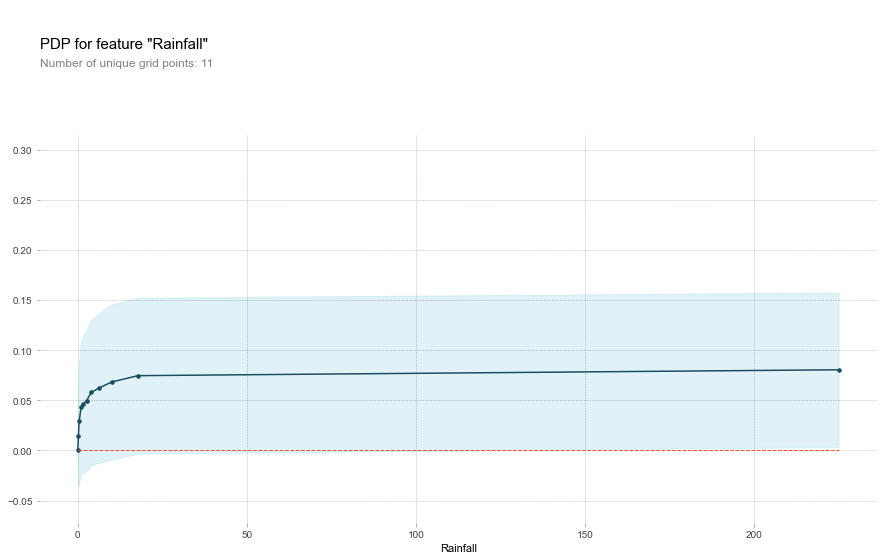

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

X_test_encoded = OrdinalEncoder(cols=['Date','Location']).fit_transform(X_test)

def pdpplot(feature):
    
    isolated = pdp_isolate(
        model=best_pipe, 
        dataset=X_test_encoded, 
        model_features=X_test_encoded.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=30 # default=10
    )
    pdp_plot(isolated, feature_name=feature)

pdpplot('Rainfall')

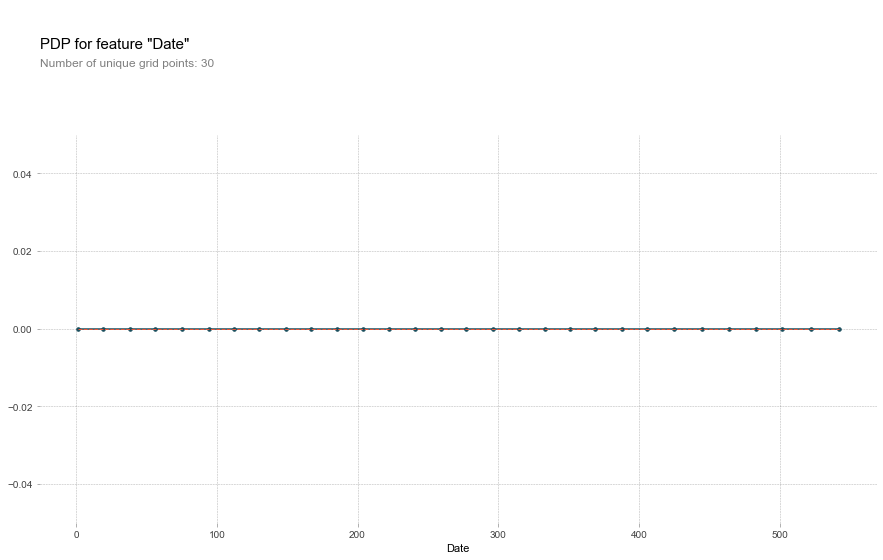

In [32]:
pdpplot('Date')

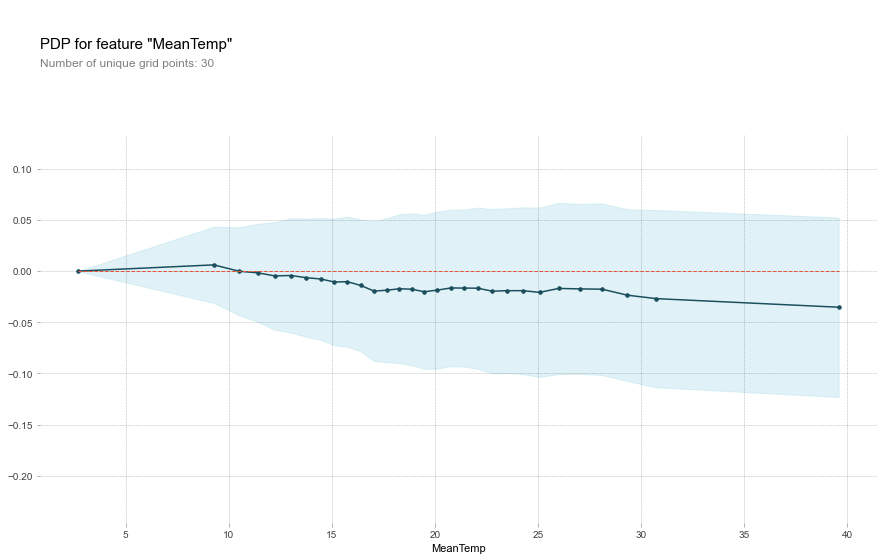

In [34]:
pdpplot('MeanTemp')

## Conclusion

- 호주 기상 데이터를 바탕으로 다음날 비가 내렸는지를 예측해 보았다.
- EDA 로 결측치 및 feature correlation 확인하였고, 특성공학을 수행하였다.
- Imbalanced 되어 있는 Target 에 대해 oversampling하여 훈련셋을 만들었다.
- LogisticRegression, DecisionTree, LightGBM, RandomForestClassifier 로 각각 CV를 적용한 모델 훈련 결과를 비교하였다.
- 가장 결과가 잘 나온 RandomForest 로 test 데이터에 적용해 보았고, baseline model 보다 상당한 성능 향상을 보였다.
- PDP Plot으로 몇 가지 feature들이 타겟 예측에 어떻게 기여했는지 살펴보았다.
- **모델이 어느 정도 날씨 예측 향상에 기여했다는 것을 확인했다.**

**아쉬운 점**
- feature importance를 살펴보지 못했다.
- 여전히 비가 오는 경우 예측의 recall 점수가 너무 낮았다.
- 좀더 다양한 모델과 hyperparameter 튜닝을 해보지 못해 아쉬웠다.

In [5]:
# non-numeric types
'''
WindGustDir : 
The direction of the strongest wind gust 
in the 24 hours to midnight
'''

aus.select_dtypes(exclude=np.number)

Date Location WindGustDir WindDir9am WindDir3pm RainToday  \
0       2008-12-01   Albury           W          W        WNW        No   
1       2008-12-02   Albury         WNW        NNW        WSW        No   
2       2008-12-03   Albury         WSW          W        WSW        No   
3       2008-12-04   Albury          NE         SE          E        No   
4       2008-12-05   Albury           W        ENE         NW        No   
...            ...      ...         ...        ...        ...       ...   
145455  2017-06-21    Uluru           E         SE        ENE        No   
145456  2017-06-22    Uluru         NNW         SE          N        No   
145457  2017-06-23    Uluru           N         SE        WNW        No   
145458  2017-06-24    Uluru          SE        SSE          N        No   
145459  2017-06-25    Uluru         NaN        ESE        ESE        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 7 columns]

/var/folders/x2/cknq9hv17x34r_v1qbmvpgdh0000gn/T/ipykernel_88063/1849155179.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anb['RainToday'] = aus['RainToday']
/var/folders/x2/cknq9hv17x34r_v1qbmvpgdh0000gn/T/ipykernel_88063/1849155179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anb['RainTomorrow'] = aus['RainTomorrow']


<AxesSubplot:>

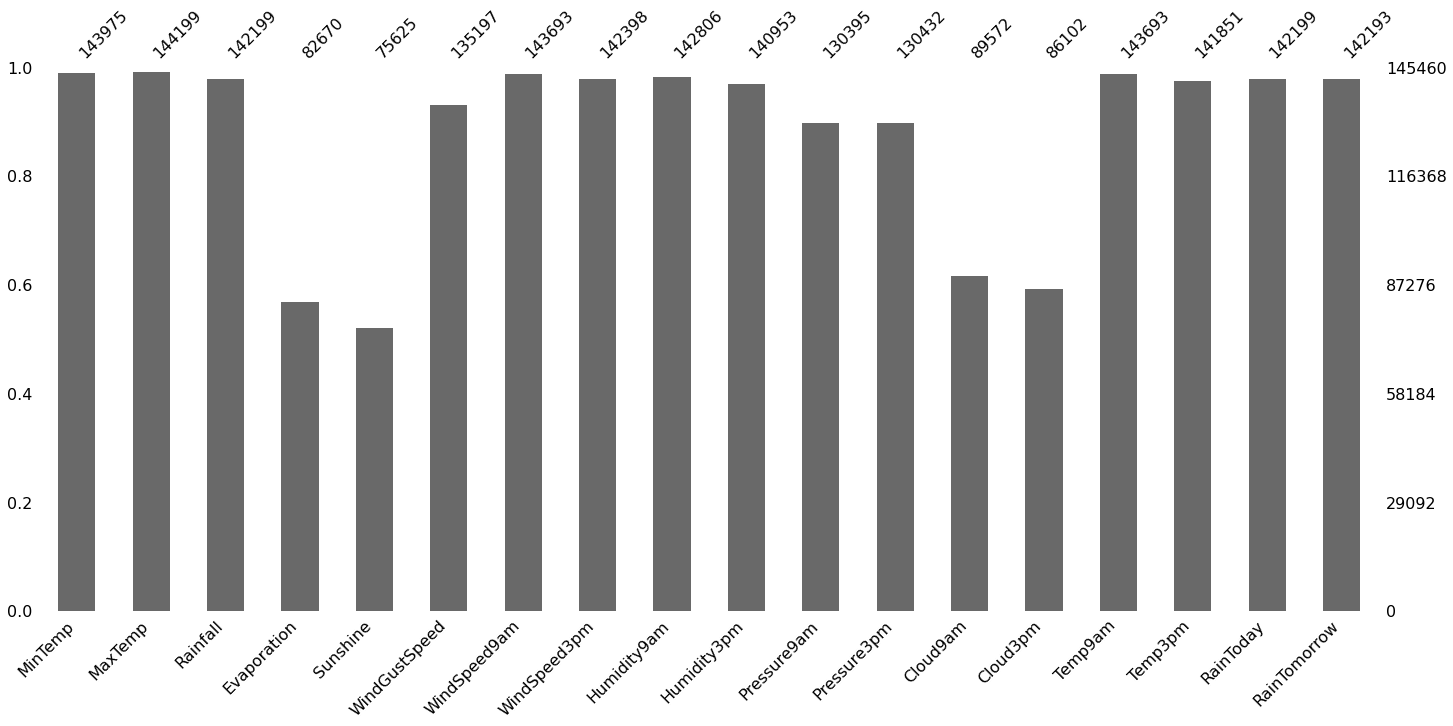

In [6]:
# numeric 결측치 확인 
anb = aus.select_dtypes(np.number)

# 가장 중요할 두 지표 붙이기
anb['RainToday'] = aus['RainToday']
anb['RainTomorrow'] = aus['RainTomorrow']
msno.bar(anb)

In [7]:
# Evaporation, Sunshine, Cloud 등 nan 값 원인 파악하기

# numeric 결측치 확인 
anb = aus.select_dtypes(np.number)

# 가장 중요할 두 지표 붙이기
anb['RainToday'] = aus['RainToday']
anb['RainTomorrow'] = aus['RainTomorrow']

# evaporation, sunshine, cloud는 너무 결측치가 많고 유추하기도 힘들다. 따라서 그냥 제거한다
anb = anb.drop(['Evaporation','Sunshine','Cloud9am','Cloud3pm'], axis=1)

# no, yes -> 0, 1 로 바꾸기
def yesno(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
anb['RainToday'] = anb['RainToday'].apply(yesno)
anb['RainTomorrow'] = anb['RainTomorrow'].apply(yesno)

# 결측치 있는 row 제거
print(len(anb))
anb = anb.dropna()
print(len(anb))
anb


145460
119590


/var/folders/x2/cknq9hv17x34r_v1qbmvpgdh0000gn/T/ipykernel_88063/2162848920.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anb['RainToday'] = aus['RainToday']
/var/folders/x2/cknq9hv17x34r_v1qbmvpgdh0000gn/T/ipykernel_88063/2162848920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anb['RainTomorrow'] = aus['RainTomorrow']


MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0          13.4     22.9       0.6           44.0          20.0          24.0   
1           7.4     25.1       0.0           44.0           4.0          22.0   
2          12.9     25.7       0.0           46.0          19.0          26.0   
3           9.2     28.0       0.0           24.0          11.0           9.0   
4          17.5     32.3       1.0           41.0           7.0          20.0   
...         ...      ...       ...            ...           ...           ...   
145454      3.5     21.8       0.0           31.0          15.0          13.0   
145455      2.8     23.4       0.0           31.0          13.0          11.0   
145456      3.6     25.3       0.0           22.0          13.0           9.0   
145457      5.4     26.9       0.0           37.0           9.0           9.0   
145458      7.8     27.0       0.0           28.0          13.0           7.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0              71.0         22.0       1007.7       1007.1     16.9     21.8   
1              44.0         25.0       1010.6       1007.8     17.2     24.3   
2              38.0         30.0       1007.6       1008.7     21.0     23.2   
3              45.0         16.0       1017.6       1012.8     18.1     26.5   
4              82.0         33.0       1010.8       1006.0     17.8     29.7   
...             ...          ...          ...          ...      ...      ...   
145454         59.0         27.0       1024.7       1021.2      9.4     20.9   
145455         51.0         24.0       1024.6       1020.3     10.1     22.4   
145456         56.0         21.0       1023.5       1019.1     10.9     24.5   
145457         53.0         24.0       1021.0       1016.8     12.5     26.1   
145458         51.0         24.0       1019.4       1016.5     15.1     26.0   

        RainToday  RainTomorrow  
0             0.0           0.0  
1             0.0           0.0  
2             0.0           0.0  
3             0.0           0.0  
4             0.0           0.0  
...           ...           ...  
145454        0.0           0.0  
145455        0.0           0.0  
145456        0.0           0.0  
145457        0.0           0.0  
145458        0.0           0.0  

[119590 rows x 14 columns]

In [7]:
anb['Temp9am'].value_counts()
    
    
    
    
    

 14.8    741
 16.6    729
 13.8    724
 14.7    719
 15.1    718
        ... 
-1.7       1
 38.3      1
-0.9       1
-3.1       1
 38.0      1
Name: Temp9am, Length: 400, dtype: int64

## baseline model

항상 비가 오지 않을 것으로 예측하는 모델을 baseline model로 한다

In [8]:
y_pred_base = pd.DataFrame(anb['RainToday'])

In [9]:
y_pred_base = pd.DataFrame({'RainTomorrow':np.zeros(len(anb['RainToday']))})
y_test = anb[['RainTomorrow']]

accuracy = classification_report(y_test[:-2], y_pred_base[:-2])
print(accuracy)

RainTomorrow
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
...              ...
119585           0.0
119586           0.0
119587           0.0
119588           0.0
119589           0.0

[119590 rows x 1 columns]

In [9]:
y_test = anb[['RainTomorrow']]
y_test

RainTomorrow
0                0.0
1                0.0
2                0.0
3                0.0
4                0.0
...              ...
145454           0.0
145455           0.0
145456           0.0
145457           0.0
145458           0.0

[119590 rows x 1 columns]

In [10]:
y_pred_base.isna().sum()

RainTomorrow    0
dtype: int64

In [11]:
y_test.isna().sum()

RainTomorrow    0
dtype: int64

In [12]:
?classification_report

In [13]:
accuracy = classification_report(y_test[:-2], y_pred_base[:-2])
print(accuracy)

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     93401
         1.0       0.00      0.00      0.00     26187

    accuracy                           0.78    119588
   macro avg       0.39      0.50      0.44    119588
weighted avg       0.61      0.78      0.68    119588



/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

0으로만 예측하는 기본모델의 accuracy 가 이미 78% 의 높은 정확도를 보인다.  
타겟의 unbalance가 심하므로 1의 sampling을 늘려 학습시키도록 한다.

## 1. Tree-based model
### 1.1. Decision Tree
Decision Tree를 통해 학습 과정을 살펴본다.

In [50]:
anb[anb.columns[:-1]]

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0          13.4     22.9       0.6           44.0          20.0          24.0   
1           7.4     25.1       0.0           44.0           4.0          22.0   
2          12.9     25.7       0.0           46.0          19.0          26.0   
3           9.2     28.0       0.0           24.0          11.0           9.0   
4          17.5     32.3       1.0           41.0           7.0          20.0   
...         ...      ...       ...            ...           ...           ...   
145454      3.5     21.8       0.0           31.0          15.0          13.0   
145455      2.8     23.4       0.0           31.0          13.0          11.0   
145456      3.6     25.3       0.0           22.0          13.0           9.0   
145457      5.4     26.9       0.0           37.0           9.0           9.0   
145458      7.8     27.0       0.0           28.0          13.0           7.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0              71.0         22.0       1007.7       1007.1     16.9     21.8   
1              44.0         25.0       1010.6       1007.8     17.2     24.3   
2              38.0         30.0       1007.6       1008.7     21.0     23.2   
3              45.0         16.0       1017.6       1012.8     18.1     26.5   
4              82.0         33.0       1010.8       1006.0     17.8     29.7   
...             ...          ...          ...          ...      ...      ...   
145454         59.0         27.0       1024.7       1021.2      9.4     20.9   
145455         51.0         24.0       1024.6       1020.3     10.1     22.4   
145456         56.0         21.0       1023.5       1019.1     10.9     24.5   
145457         53.0         24.0       1021.0       1016.8     12.5     26.1   
145458         51.0         24.0       1019.4       1016.5     15.1     26.0   

        RainToday  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
145454        0.0  
145455        0.0  
145456        0.0  
145457        0.0  
145458        0.0  

[119590 rows x 13 columns]

In [ ]:
decisiontree = Deci 

In [44]:
?LogisticRegression

In [43]:
logistic = LogisticRegression(random_state=0)
logistic.fit()

In [47]:
?cross_val_score

In [63]:
cross_val_score(
    LinearRegression(),
    anb[anb.columns[:-1]],
    anb[anb.columns[-1]],
    cv=5,
    n_jobs=-1,
    verbose=1,
#     scoring=''
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


array([0.29916971, 0.28958156, 0.32847734, 0.35441753, 0.35904853])

In [79]:
#baseline model - logisticregression

train, test = train_test_split(anb, train_size=0.8, random_state=22)
print(train.shape, test.shape)

features = anb.columns[:-1]
target = anb.columns[-1]

logistic = LogisticRegression(random_state=0)
logistic.fit(train[features],
            train[target])
y_pred_log = logistic.predict(test[features])

print(20*'='+' Baseline model - LogisticRegression '+20*'=')
print(classification_report(test[target], y_pred_log))


(95672, 14) (23918, 14)
==================== Baseline model - LogisticRegression ====================
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     18706
         1.0       0.74      0.45      0.56      5212

    accuracy                           0.85     23918
   macro avg       0.80      0.70      0.73     23918
weighted avg       0.84      0.85      0.83     23918



/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
precision    recall  f1-score   support

           0       0.86      0.95      0.90     15730
           1       0.74      0.47      0.58      4682

    accuracy                           0.84     20412
   macro avg       0.80      0.71      0.74     20412
weighted avg       0.83      0.84      0.83     20412

In [72]:
cross_val_score(
    LogisticRegression(),
    anb[anb.columns[:-1]],
    anb[anb.columns[-1]],
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='precision'
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


array([0.68946302, 0.66946993, 0.73208092, 0.78332782, 0.77933965])

In [113]:
cross_val_score(
    RandomForestClassifier(),
    anb[anb.columns[:-1]],
    anb[anb.columns[-1]],
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='f1'
               )

array([0.59349686, 0.58895569, 0.59503228, 0.58653499, 0.59360411])

- 불균형한 데이터의 샘플링 방법?
- 시계열 데이터 이므로 이에 맞는 모델을 잘 선택해야 한다.
- 데이터 전처리  
    - 풍향
    - 날짜
    - 기타 정규화

In [80]:
# feature 살펴보기
sns.barplot()

NameError: name 'sns' is not defined

In [82]:
aus.select_dtypes(exclude=np.number)

Date Location WindGustDir WindDir9am WindDir3pm RainToday  \
0       2008-12-01   Albury           W          W        WNW        No   
1       2008-12-02   Albury         WNW        NNW        WSW        No   
2       2008-12-03   Albury         WSW          W        WSW        No   
3       2008-12-04   Albury          NE         SE          E        No   
4       2008-12-05   Albury           W        ENE         NW        No   
...            ...      ...         ...        ...        ...       ...   
145455  2017-06-21    Uluru           E         SE        ENE        No   
145456  2017-06-22    Uluru         NNW         SE          N        No   
145457  2017-06-23    Uluru           N         SE        WNW        No   
145458  2017-06-24    Uluru          SE        SSE          N        No   
145459  2017-06-25    Uluru         NaN        ESE        ESE        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 7 columns]

In [85]:
aus.Location.value_counts()

Canberra            3436
Sydney              3344
Darwin              3193
Melbourne           3193
Brisbane            3193
Adelaide            3193
Perth               3193
Hobart              3193
Albany              3040
MountGambier        3040
Ballarat            3040
Townsville          3040
GoldCoast           3040
Cairns              3040
Launceston          3040
AliceSprings        3040
Bendigo             3040
Albury              3040
MountGinini         3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
Woomera             3009
Nuriootpa           3009
Cobar               3009
CoffsHarbour        3009
Moree               3009
Sale                3009
PerthAirport        3009
PearceRAAF          3009
Witchcliffe         3009
BadgerysCreek       3009
Mildura             3009
NorfolkIsland       3009
MelbourneAirport    3009
Richmond            3009
SydneyAirport       3009
WaggaWagga          3009
Williamtown         3009


<AxesSubplot:xlabel='WindGustDir', ylabel='Count'>

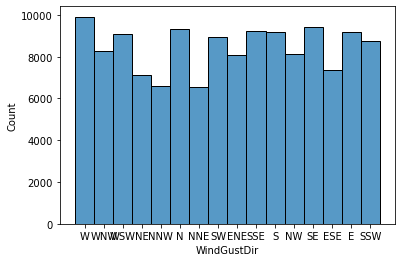

In [86]:
sns.histplot(aus.WindGustDir)

<AxesSubplot:xlabel='Location', ylabel='Count'>

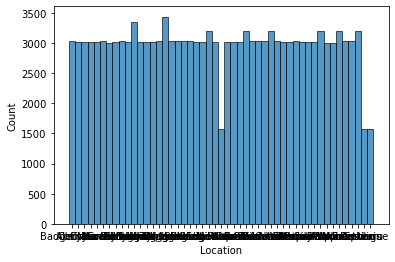

In [84]:
sns.histplot(aus['Location'])

Categorical features 대부분이 가짓수가 많고 (High Cardinality), 그 빈도도 꽤 일정하기 때문에 PCA로 차원축소를 진행하도록 한다.

In [99]:
# Date conversion
aus['Date'] = pd.to_datetime(aus['Date'])
aus

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1      2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2      2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3      2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4      2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
...           ...      ...      ...      ...       ...          ...       ...   
145455 2017-06-21    Uluru      2.8     23.4       0.0          NaN       NaN   
145456 2017-06-22    Uluru      3.6     25.3       0.0          NaN       NaN   
145457 2017-06-23    Uluru      5.4     26.9       0.0          NaN       NaN   
145458 2017-06-24    Uluru      7.8     27.0       0.0          NaN       NaN   
145459 2017-06-25    Uluru     14.9      NaN       0.0          NaN       NaN   

       WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0                W           44.0          W  ...        71.0         22.0   
1              WNW           44.0        NNW  ...        44.0         25.0   
2              WSW           46.0          W  ...        38.0         30.0   
3               NE           24.0         SE  ...        45.0         16.0   
4                W           41.0        ENE  ...        82.0         33.0   
...            ...            ...        ...  ...         ...          ...   
145455           E           31.0         SE  ...        51.0         24.0   
145456         NNW           22.0         SE  ...        56.0         21.0   
145457           N           37.0         SE  ...        53.0         24.0   
145458          SE           28.0        SSE  ...        51.0         24.0   
145459         NaN            NaN        ESE  ...        62.0         36.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1       8.0       NaN     16.9     21.8   
1            1010.6       1007.8       NaN       NaN     17.2     24.3   
2            1007.6       1008.7       NaN       2.0     21.0     23.2   
3            1017.6       1012.8       NaN       NaN     18.1     26.5   
4            1010.8       1006.0       7.0       8.0     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
145455       1024.6       1020.3       NaN       NaN     10.1     22.4   
145456       1023.5       1019.1       NaN       NaN     10.9     24.5   
145457       1021.0       1016.8       NaN       NaN     12.5     26.1   
145458       1019.4       1016.5       3.0       2.0     15.1     26.0   
145459       1020.2       1017.9       8.0       8.0     15.0     20.9   

        RainToday  RainTomorrow  
0              No            No  
1              No            No  
2              No            No  
3              No            No  
4              No            No  
...           ...           ...  
145455         No            No  
145456         No            No  
145457         No            No  
145458         No            No  
145459         No           NaN  

[145460 rows x 23 columns]

In [235]:
anb[anb.corr() > 0.6]

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0           NaN      NaN       NaN            NaN           NaN           NaN   
1           NaN      NaN       NaN            NaN           NaN           NaN   
2           NaN      NaN       NaN            NaN           NaN           NaN   
3           NaN      NaN       NaN            NaN           NaN           NaN   
4           NaN      NaN       NaN            NaN           NaN           NaN   
...         ...      ...       ...            ...           ...           ...   
145454      NaN      NaN       NaN            NaN           NaN           NaN   
145455      NaN      NaN       NaN            NaN           NaN           NaN   
145456      NaN      NaN       NaN            NaN           NaN           NaN   
145457      NaN      NaN       NaN            NaN           NaN           NaN   
145458      NaN      NaN       NaN            NaN           NaN           NaN   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0               NaN          NaN          NaN          NaN      NaN      NaN   
1               NaN          NaN          NaN          NaN      NaN      NaN   
2               NaN          NaN          NaN          NaN      NaN      NaN   
3               NaN          NaN          NaN          NaN      NaN      NaN   
4               NaN          NaN          NaN          NaN      NaN      NaN   
...             ...          ...          ...          ...      ...      ...   
145454          NaN          NaN          NaN          NaN      NaN      NaN   
145455          NaN          NaN          NaN          NaN      NaN      NaN   
145456          NaN          NaN          NaN          NaN      NaN      NaN   
145457          NaN          NaN          NaN          NaN      NaN      NaN   
145458          NaN          NaN          NaN          NaN      NaN      NaN   

        RainToday  RainTomorrow Date  
0             NaN           NaN  NaT  
1             NaN           NaN  NaT  
2             NaN           NaN  NaT  
3             NaN           NaN  NaT  
4             NaN           NaN  NaT  
...           ...           ...  ...  
145454        NaN           NaN  NaT  
145455        NaN           NaN  NaT  
145456        NaN           NaN  NaT  
145457        NaN           NaN  NaT  
145458        NaN           NaN  NaT  

[119590 rows x 15 columns]

In [16]:
%matplotlib inline

<AxesSubplot:>

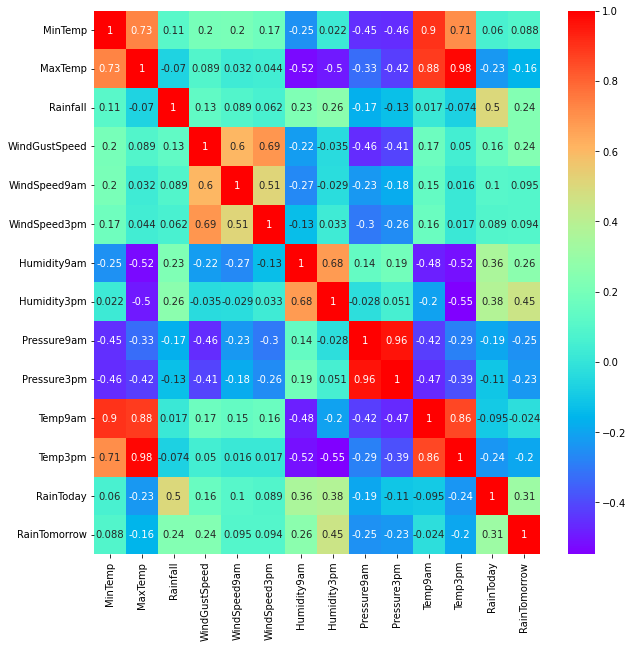

In [232]:
# EDA
# 내일 비오는 것과 상관관계가 높은 / 낮은 지표 탐색하기.
plt.figure(figsize=(10,10))
sns.heatmap(anb.corr(),
           annot=True,
           cmap='rainbow')

<AxesSubplot:>

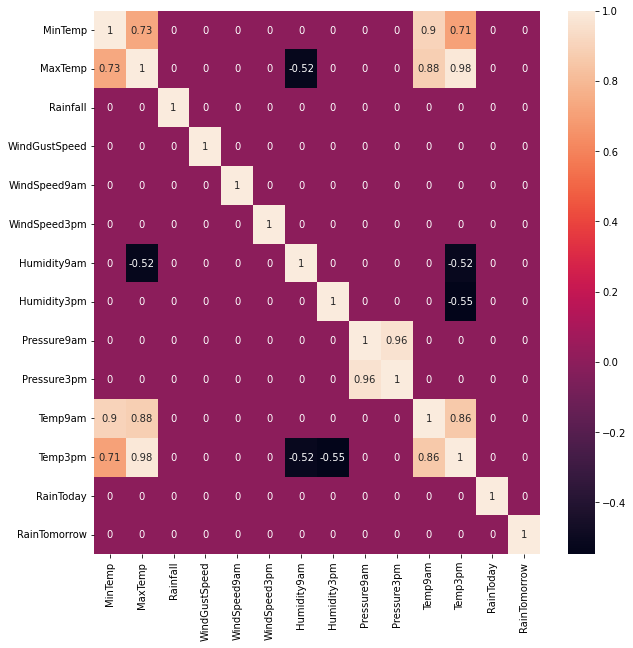

In [243]:
anb_high = anb.corr().copy()
# anb_high[anb_high > 0.7] = 1
# anb_high[anb_high < -0.5] = -1
anb_high[~(anb_high > 0.7) & ~(anb_high < -0.5)] = 0

plt.figure(figsize=(10,10))
sns.heatmap(anb_high,
           annot=True,
           )

In [16]:
%matplotlib inline

Correlation 분석 결과: 
- MinTemp 와 MaxTemp correlation이 70% 이상이다. 
    - MeanTemp를 만들고 이것만 쓴다.
- Temp9am, Temp3pm 의 correlation이 너무 높다. 쓰지 않고 마찬가지로 MeanTemp만 만들고 쓰자.
- 

<Figure size 1440x1440 with 0 Axes>

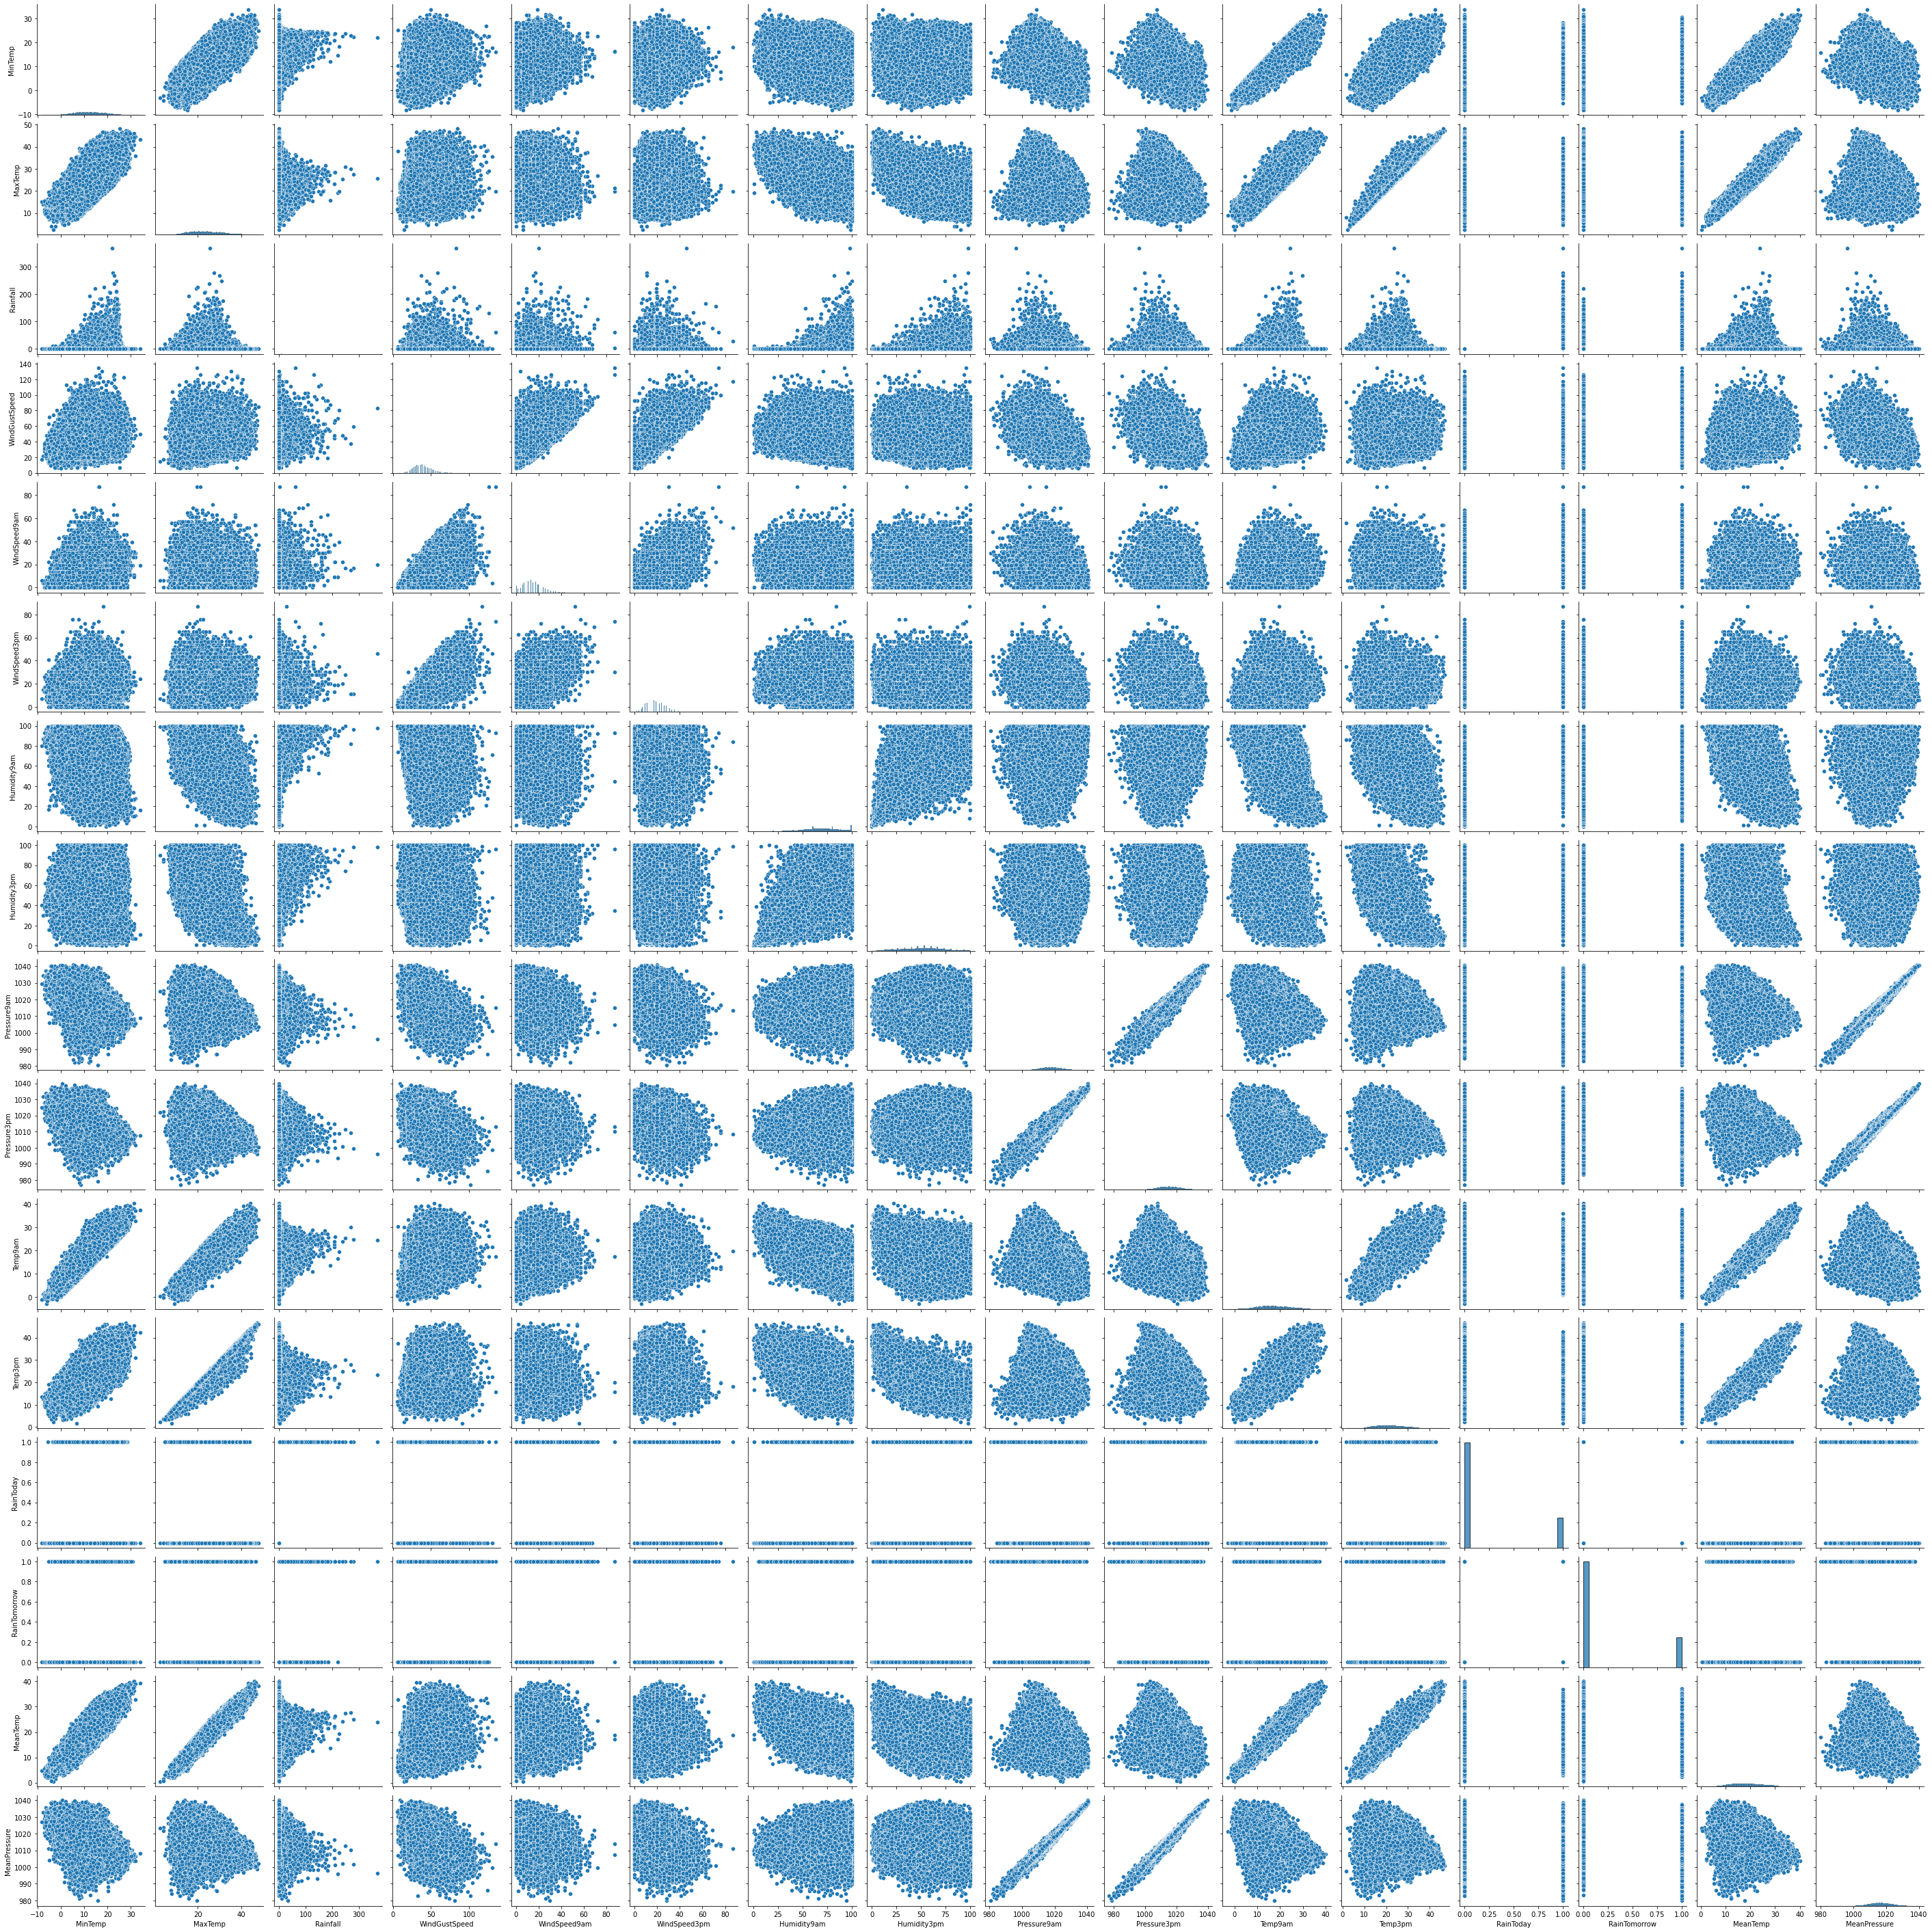

In [17]:
plt.figure(figsize=(20,20))
sns.pairplot(anb)

In [26]:
aus

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8       None          None  
1          24.3       None          None  
2          23.2       None          None  
3          26.5       None          None  
4          29.7       None          None  
...         ...        ...           ...  
145455     22.4       None          None  
145456     24.5       None          None  
145457     26.1       None          None  
145458     26.0       None          None  
145459     20.9       None          None  

[145460 rows x 23 columns]

In [32]:
# 각 파라미터에 대한 0,1 의 분포?
# RainToday, RainTomorrow 의 yes,no 를 1, 0 으로 바꾼다.
# no, yes -> 0, 1 로 바꾸기
def yesno(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
aus['RainToday'] = aus['RainToday'].apply(yesno)
aus['RainTomorrow'] = aus['RainTomorrow'].apply(yesno)


In [38]:
aus[['WindGustDir','RainTomorrow']].groupby('WindGustDir').mean()

# WindGustDir WindGustSpeed

RainTomorrow
WindGustDir              
E                0.148826
ENE              0.161161
ESE              0.164271
N                0.271449
NE               0.186827
NNE              0.230219
NNW              0.283951
NW               0.285393
S                0.225388
SE               0.186164
SSE              0.195152
SSW              0.220325
SW               0.205070
W                0.266564
WNW              0.282048
WSW              0.234243

In [20]:
aus[aus['WindGustDir'] == 'E']

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
77      2009-02-16   Albury     17.2     31.1       0.0          NaN   
168     2009-05-18   Albury      2.6     19.7       0.0          NaN   
170     2009-05-20   Albury      5.1     18.6       0.0          NaN   
173     2009-05-23   Albury      6.2     22.9       0.0          NaN   
176     2009-05-26   Albury     11.6     18.1       4.2          NaN   
...            ...      ...      ...      ...       ...          ...   
145446  2017-06-12    Uluru      5.1     19.7       0.0          NaN   
145450  2017-06-16    Uluru      5.2     24.3       0.0          NaN   
145453  2017-06-19    Uluru      7.4     20.6       0.0          NaN   
145454  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
77           NaN           E           35.0         SE  ...        43.0   
168          NaN           E           13.0        NaN  ...        82.0   
170          NaN           E           13.0        SSE  ...        75.0   
173          NaN           E           30.0         NE  ...        71.0   
176          NaN           E           19.0          E  ...        97.0   
...          ...         ...            ...        ...  ...         ...   
145446       NaN           E           46.0        ESE  ...        56.0   
145450       NaN           E           24.0         SE  ...        53.0   
145453       NaN           E           35.0        ESE  ...        63.0   
145454       NaN           E           31.0        ESE  ...        59.0   
145455       NaN           E           31.0         SE  ...        51.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
77             22.0       1017.7       1013.8       NaN       NaN     21.4   
168            34.0       1024.7       1021.2       NaN       NaN      8.8   
170            57.0       1022.8       1020.5       7.0       7.0     12.4   
173            37.0       1022.2       1019.4       NaN       NaN     11.9   
176            74.0       1021.4       1019.2       8.0       3.0     13.6   
...             ...          ...          ...       ...       ...      ...   
145446         29.0       1028.5       1025.8       NaN       NaN      8.5   
145450         24.0       1023.8       1020.0       NaN       NaN     12.3   
145453         33.0       1027.2       1023.3       NaN       NaN     11.0   
145454         27.0       1024.7       1021.2       NaN       NaN      9.4   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   

        Temp3pm  RainToday  RainTomorrow  
77         29.5         No            No  
168        18.7         No            No  
170        18.0         No            No  
173        21.7         No            No  
176        17.4        Yes            No  
...         ...        ...           ...  
145446     19.2         No            No  
145450     23.3         No            No  
145453     20.3         No            No  
145454     20.9         No            No  
145455     22.4         No            No  

[9181 rows x 23 columns]

In [163]:
aus.loc[anb.index,'Date']
# len(anb['Date'])

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145454   2017-06-20
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
Name: Date, Length: 119590, dtype: datetime64[ns]

In [105]:
features = anb.columns.drop(['RainTomorrow','Date'])
target = ['RainTomorrow']

In [107]:
?OrdinalEncoder

In [108]:
ordinal = OrdinalEncoder(cols=['Date'])
anb_ord = ordinal.fit_transform(anb)
cross_val_score(
    LogisticRegression(),
    anb_ord[features],
    anb_ord[target],
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1'
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


array([0.5927055 , 0.57351817, 0.58249971, 0.57329621, 0.57466554])

In [112]:
cross_val_score(
    LogisticRegression(),
    anb[anb.columns[:-1]],
    anb[anb.columns[-1]],
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1'
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


array([0.5927055 , 0.57351817, 0.58249971, 0.57329621, 0.57466554])

In [109]:
anb_ord

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0          13.4     22.9       0.6           44.0          20.0          24.0   
1           7.4     25.1       0.0           44.0           4.0          22.0   
2          12.9     25.7       0.0           46.0          19.0          26.0   
3           9.2     28.0       0.0           24.0          11.0           9.0   
4          17.5     32.3       1.0           41.0           7.0          20.0   
...         ...      ...       ...            ...           ...           ...   
145454      3.5     21.8       0.0           31.0          15.0          13.0   
145455      2.8     23.4       0.0           31.0          13.0          11.0   
145456      3.6     25.3       0.0           22.0          13.0           9.0   
145457      5.4     26.9       0.0           37.0           9.0           9.0   
145458      7.8     27.0       0.0           28.0          13.0           7.0   

        Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0              71.0         22.0       1007.7       1007.1     16.9     21.8   
1              44.0         25.0       1010.6       1007.8     17.2     24.3   
2              38.0         30.0       1007.6       1008.7     21.0     23.2   
3              45.0         16.0       1017.6       1012.8     18.1     26.5   
4              82.0         33.0       1010.8       1006.0     17.8     29.7   
...             ...          ...          ...          ...      ...      ...   
145454         59.0         27.0       1024.7       1021.2      9.4     20.9   
145455         51.0         24.0       1024.6       1020.3     10.1     22.4   
145456         56.0         21.0       1023.5       1019.1     10.9     24.5   
145457         53.0         24.0       1021.0       1016.8     12.5     26.1   
145458         51.0         24.0       1019.4       1016.5     15.1     26.0   

        RainToday  RainTomorrow  Date  
0             0.0           0.0     1  
1             0.0           0.0     2  
2             0.0           0.0     3  
3             0.0           0.0     4  
4             0.0           0.0     5  
...           ...           ...   ...  
145454        0.0           0.0  2969  
145455        0.0           0.0  2970  
145456        0.0           0.0  2971  
145457        0.0           0.0  2972  
145458        0.0           0.0  2973  

[119590 rows x 15 columns]

In [115]:
?StandardScaler

In [114]:
#이전 값 그냥 남겨놓음.
cross_val_score(
    RandomForestClassifier(),
    anb_ord_scaled[features],
    anb_ord_scaled[target],
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1'
               )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.8s remaining:   20.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished


array([0.58667883, 0.591287  , 0.59792009, 0.58667949, 0.58746797])

In [125]:
anb_ord_scaled.shape

(119590, 15)

In [128]:
len(features+target)

13

In [11]:
anb['Date'] = aus.loc[anb.index,'Date']

#meanTemp 계산
anb['MeanTemp'] = anb.loc[:,['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].mean(axis=1)

#meanpressure 계산
anb['MeanPressure'] = anb.loc[:,['Pressure9am', 'Pressure3pm']].mean(axis=1)

features = anb.columns.drop(['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm',
                             'Pressure9am', 'Pressure3pm',
                             'RainToday', 'RainTomorrow'])  # RainToday는 나중에 넣어준다
target = ['RainTomorrow']

ordinal = OrdinalEncoder(cols=['Date'])
anb_ord = ordinal.fit_transform(anb[features])

# 정규화
anb_ord_scaled = StandardScaler().fit_transform(anb_ord)

anb_df = pd.DataFrame(np.column_stack((anb_ord_scaled,
                                       np.vstack((anb.loc[:,'RainToday'].values, anb.loc[:,'RainTomorrow'].values)).T)),
                      columns=np.append(features,['RainToday','RainTomorrow'])
                     )

# del(anb_df['RainToday'])
# anb_ord_scaled['RainTomorrow'] = anb.loc[:,'RainTomorrow'].values
# anb_df

# anb_ord_scaled

# cross_val_score(
#     RandomForestClassifier(),
#     anb_df[np.append(features,'RainToday')],
#     anb_df[target],
#     cv=5,
#     n_jobs=-1,
#     verbose=1,
#     scoring='accuracy'
#                )


cross_val_score(
    LGBMClassifier(random_state=0),
    anb_df[np.append(features,'RainToday')],
    anb_df[target],
    cv=5,
#     n_jobs=1,
    verbose=1,
    scoring='accuracy'
               )


# train, test = train_test_split(anb_df[np.append(features,['RainToday','RainTomorrow'])],
#                               train_size=0.8,
#                               random_state=0)
# X_train = train[np.append(features,'RainToday')]
# y_train = train[target]

# X_test = test[np.append(features,'RainToday')]
# y_test = test[target]

# gbm = LGBMClassifier(random_state=0)

# gbm.fit(X_train, y_train)

# y_pred = gbm.predict(X_test)

# print(classification_report(y_test, y_pred))



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wooseokpark/miniforge3/env

array([0.84890041, 0.84509574, 0.84660089, 0.85759679, 0.85642612])

In [41]:
aus['RainTomorrow'].value_counts()

0.0    110316
1.0     31877
Name: RainTomorrow, dtype: int64

In [39]:
?cross_val_score

==================== Baseline model - LogisticRegression ====================
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     18706
         1.0       0.74      0.45      0.56      5212

    accuracy                           0.85     23918
   macro avg       0.80      0.70      0.73     23918
weighted avg       0.84      0.85      0.83     23918

In [193]:
rray([0.58667883, 0.591287  , 0.59792009, 0.58667949, 0.58746797])

In [9]:
X_test

Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
26730 -0.274179       1.995027      1.777584      3.102805     0.141680   
32284 -0.274179      -0.378914     -0.609781     -0.240019    -0.224253   
73344  0.009339       0.437128     -0.155044      0.797409     0.873545   
22016 -0.274179      -1.343327     -1.632937     -0.470559     1.605411   
80850 -0.203300      -0.749842     -0.837149     -1.392718     0.664441   
...         ...            ...           ...           ...          ...   
30335 -0.274179      -0.527285     -0.609781     -0.470559    -0.067425   
7528  -0.250553      -0.675656     -0.155044     -0.240019     0.925821   
1287  -0.132420      -1.046585     -0.950833     -0.931638     1.657687   
10867 -0.274179       0.733871     -0.609781      1.373758    -0.171977   
94210 -0.226926      -1.194956     -1.632937     -1.392718     1.657687   

       Humidity3pm      Date  MeanTemp  MeanPressure  RainToday  
26730     0.973040  0.623028  0.381790     -0.100749        0.0  
32284     0.248112  0.973310  1.164295      0.063751        0.0  
73344     0.973040 -0.082069  1.092433     -0.386835        1.0  
22016    -0.331831  1.189827 -0.736074      0.836185        0.0  
80850    -0.090188 -1.643031  0.042439     -0.179423        0.0  
...            ...       ...       ...           ...        ...  
30335    -0.766788  1.347397 -0.576379     -0.043531        0.0  
7528     -0.235174  1.648933 -0.915731      1.372597        0.0  
1287      0.779726 -0.306521 -1.642342     -0.007771        1.0  
10867     0.731398  1.368935  0.637302      0.392751        0.0  
94210     1.263012  0.749991 -0.588356      0.707446        0.0  

[23918 rows x 10 columns]

In [267]:
anb_df

Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  Humidity9am  \
0      -0.203300       0.288757      0.640744      0.566869     0.141680   
1      -0.274179       0.288757     -1.178201      0.336330    -1.269775   
2      -0.274179       0.437128      0.527060      0.797409    -1.583432   
3      -0.274179      -1.194956     -0.382412     -1.162178    -1.217499   
4      -0.156047       0.066200     -0.837149      0.105790     0.716717   
...          ...            ...           ...           ...          ...   
119585 -0.274179      -0.675656      0.072324     -0.701099    -0.485634   
119586 -0.274179      -0.675656     -0.155044     -0.931638    -0.903843   
119587 -0.274179      -1.343327     -0.155044     -1.162178    -0.642462   
119588 -0.274179      -0.230543     -0.609781     -1.162178    -0.799290   
119589 -0.274179      -0.898213     -0.155044     -1.392718    -0.903843   

        Humidity3pm  RainToday      Date  MeanTemp  MeanPressure  RainTomorrow  
0         -1.395059  -1.765459 -0.001477 -1.295160           0.0           0.0  
1         -1.250073  -1.764326 -0.041401 -1.037682           0.0           0.0  
2         -1.008431  -1.763192  0.309928 -1.187878           0.0           0.0  
3         -1.685030  -1.762059  0.270004 -0.179423           0.0           0.0  
4         -0.863445  -1.760925  0.888822 -1.152117           0.0           0.0  
...             ...        ...       ...       ...           ...           ...  
119585    -1.153416   1.599055 -0.775998  0.929163           0.0           0.0  
119586    -1.298402   1.600189 -0.652234  0.857641           0.0           0.0  
119587    -1.443388   1.601322 -0.428661  0.693141           0.0           0.0  
119588    -1.298402   1.602456 -0.165165  0.349838           0.0           0.0  
119589    -1.298402   1.603589  0.034454  0.213946           0.0           0.0  

[119590 rows x 11 columns]

/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/wooseokpark/miniforge3/envs/kaggle/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [209]:
np.column_stack((anb_ord_scaled,
             np.vstack((anb.loc[:,'RainToday'].values, anb.loc[:,'RainTomorrow'].values)).T)).shape
                      

(119590, 15)

In [213]:
np.append(anb.columns.drop(['RainToday','RainTomorrow']),['RainToday','RainTommrow'])

array(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'Date', 'RainToday',
       'RainTommrow'], dtype=object)

In [171]:
anb.loc[:,'RainTomorrow'].values

array([0., 0., 0., ..., 0., 0., 0.])

In [155]:
anb_ord_scaled['RainTomorrow'].isna().sum()

20206

In [139]:
np.append(features,target).shape

(15,)

In [140]:
pd.DataFrame(anb_ord_scaled, columns=np.append(features,target))

MinTemp   MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
0       0.159160 -0.083870 -0.203300       0.288757      0.640744   
1      -0.783124  0.231021 -0.274179       0.288757     -1.178201   
2       0.080636  0.316900 -0.274179       0.437128      0.527060   
3      -0.500439  0.646104 -0.274179      -1.194956     -0.382412   
4       0.803054  1.261572 -0.156047       0.066200     -0.837149   
...          ...       ...       ...            ...           ...   
119585 -1.395608 -0.241315 -0.274179      -0.675656      0.072324   
119586 -1.505541 -0.012304 -0.274179      -0.675656     -0.155044   
119587 -1.379903  0.259647 -0.274179      -1.343327     -0.155044   
119588 -1.097218  0.488659 -0.274179      -0.230543     -0.609781   
119589 -0.720305  0.502972 -0.274179      -0.898213     -0.155044   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
0           0.566869     0.141680    -1.395059    -1.402514    -1.161493   
1           0.336330    -1.269775    -1.250073    -0.993975    -1.061769   
2           0.797409    -1.583432    -1.008431    -1.416602    -0.933553   
3          -1.162178    -1.217499    -1.685030    -0.007845    -0.349456   
4           0.105790     0.716717    -0.863445    -0.965799    -1.318202   
...              ...          ...          ...          ...          ...   
119585     -0.701099    -0.485634    -1.153416     0.992373     0.847231   
119586     -0.931638    -0.903843    -1.298402     0.978285     0.719015   
119587     -1.162178    -0.642462    -1.443388     0.823322     0.548060   
119588     -1.162178    -0.799290    -1.298402     0.471133     0.220395   
119589     -1.392718    -0.903843    -1.298402     0.245732     0.177656   

         Temp9am   Temp3pm  RainToday      Date  RainTomorrow  
0      -0.044318 -0.026148  -0.532718 -0.529496     -1.765459  
1       0.002198  0.339735  -0.532718 -0.529496     -1.764326  
2       0.591400  0.178746  -0.532718 -0.529496     -1.763192  
3       0.141745  0.661713  -0.532718 -0.529496     -1.762059  
4       0.095229  1.130043  -0.532718 -0.529496     -1.760925  
...          ...       ...        ...       ...           ...  
119585 -1.207218 -0.157866  -0.532718 -0.529496      1.599055  
119586 -1.098681  0.061664  -0.532718 -0.529496      1.600189  
119587 -0.974638  0.369006  -0.532718 -0.529496      1.601322  
119588 -0.726553  0.603171  -0.532718 -0.529496      1.602456  
119589 -0.323414  0.588536  -0.532718 -0.529496      1.603589  

[119590 rows x 15 columns]

In [96]:
ordinal = OrdinalEncoder()
ordinal.fit(dat)
dat2 = ordinal.transform(dat)


Date
0      2008-12-01
1      2008-12-02
2      2008-12-03
3      2008-12-04
4      2008-12-05
...           ...
145455 2017-06-21
145456 2017-06-22
145457 2017-06-23
145458 2017-06-24
145459 2017-06-25

[145460 rows x 1 columns]